In [8]:
import math as m
import numpy as np
import random as r

# Units is in m, s
SOUND_V = 343 # Speed of sound (m/s)
# ARRAY_SIDE_D = 0.02 # Distance between mic (m)
ARRAY_SIDE_D = 0.05 # Distance between mic (m)
PROC_MICRO_RES = 8e-6 # The resolution of the measurement in the microcontroller (s)

Circumradius: 0.021650635094610966
micPos: (0.021650635094610966, 0.0)
micPos: (-0.010825317547305478, 0.018750000000000003)
micPos: (-0.010825317547305494, -0.018749999999999996)


(-0.012449115179401317,
 0.02327443272670679,
 -0.020624999999999998,
 0.020625000000000004)

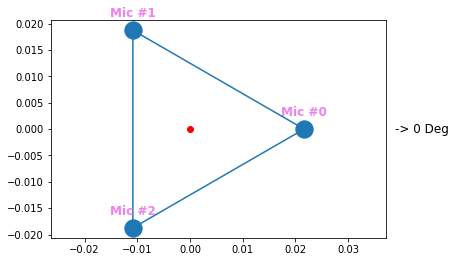

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# First, we create our microphone array in the form of an
# equilateral triangle. The center of the triangle is 0, 0
CIRCUMRADIUS = ARRAY_SIDE_D/2*m.sin(m.pi/3) # Equilateral triangle angle is pi/3
print(f"Circumradius: {CIRCUMRADIUS}")

# Mic positioning
mics = [ [m.cos(i*(m.pi*2/3))*CIRCUMRADIUS, m.sin(i*(m.pi*2/3))*CIRCUMRADIUS] for i in range(3)]
mici = [ i for i in range(len(mics)) ] # Mic index, when we reorder we have to reorder this too
for x, y in mics:
  print(f"micPos: ({x}, {y})")
micX, micY = zip(*mics)

# Display
plt.scatter([0], [0], c="red") # Center of the triangle
plt.scatter(micX, micY, s=300) # Draw mic position
plt.plot(micX + micX[:1], micY + micY[:1]) # Draw outline

# Draw microphone numbers
for i in range(len(mics)):
  plt.text(mics[i][0], mics[i][1] + ARRAY_SIDE_D*.05, (f"Mic #{str(i)}"), c="violet", size="large", weight="bold", ha="center")
  
plt.figtext(0.92, 0.5, "-> 0 Deg", size="large", va="center")
plt.axis("equal")

Sound source: (-0.014851559715991147, 0.15569176355517758)


(-0.016676669456521253,
 0.02347574483514107,
 -0.027472088177758876,
 0.16441385173293646)

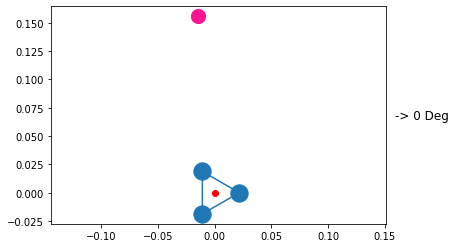

In [10]:
randfl = lambda a, b: r.random() * (b - a) + a
def random_in_circ(centerx, centery, ra):
  ra = ra * m.sqrt(r.random())
  t = r.random() * 2 * m.pi
  return (centerx + ra * m.cos(t), centery + ra * m.sin(t))

def random_in_circ_except(centerx, centery, ra, ranot):
  val = random_in_circ(centerx, centery, ra)
  while (val[0] - centerx) ** 2 + (val[1] - centery) ** 2 < ranot ** 2:
    val = random_in_circ(centerx, centery, ra)
  return val
  
# sourcex, sourcey = [-0.03, 0.012]
# sourcex, sourcey = [0.02, -0.001]
# sourcex, sourcey = [-0.00433, -0.01]
# sourcex, sourcey = [-0.01, -0.0075]
# sourcex, sourcey = [randfl(-0.3, 0.3) for _ in range(2)]
sourcex, sourcey = random_in_circ_except(0, 0, 0.4, ARRAY_SIDE_D)

print(f"Sound source: ({sourcex}, {sourcey})")

plt.scatter([0], [0], c="red") # Center of the triangle
plt.scatter(micX, micY, s=300) # Draw mic position
plt.plot(micX + micX[:1], micY + micY[:1]) # Draw outline
plt.scatter([sourcex], [sourcey], c="deeppink", s=200) # Source location
plt.figtext(0.92, 0.5, "-> 0 Deg", size="large", va="center")
plt.axis("equal")

To be able to simulate the real life conditions, we would need to get the time
delta between each mic with a python simulation. We simulate it by getting which
microphone gets hit first by the sound wave.

We can simulate the time delta by doing a projection from the closest mic to the
second closest mic, and then divide it by the speed of sound formula.

Delta between mic (0-1 is 7.6565e-05s)
Delta between mic (0-2 is 0.00014571s)


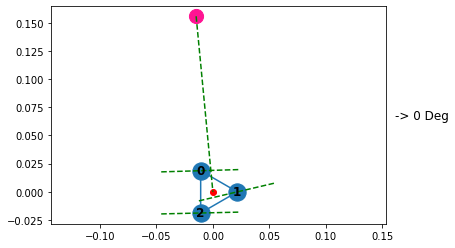

In [11]:
# Sort the mic based on which is closest
def sort_mic(key):
  return m.sqrt((key[0][0] - sourcex) ** 2 + (key[0][1] - sourcey) ** 2)

miczipped = list(zip(mics, mici))
miczipped.sort(key=sort_mic)
mics, mici = list(zip(*miczipped))

plt.scatter([0], [0], c="red") # Center of the triangle
plt.scatter(micX, micY, s=300) # Draw mic position
plt.plot(micX + micX[:1], micY + micY[:1]) # Draw outline
plt.scatter([sourcex], [sourcey], c="deeppink", s=200) # Source location

# Draw the order which mic receives the sound first
for i in range(len(mics)):
  plt.text(*mics[i], str(i), c="black", size="large", weight="bold", va="center", ha="center")
plt.figtext(0.92, 0.5, "-> 0 Deg", size="large", va="center")
plt.axis("equal")

# Draw line from source to mic one
plt.plot([sourcex, 0], [sourcey, 0], color="green", linestyle="dashed")

for x, y in mics:
  # Draw the perpendicular lines between mic
  deg = m.pi/2 + m.atan2(sourcey - y, sourcex - x)
  l = ARRAY_SIDE_D * .7
  plt.plot(
    [x + m.cos(deg) * l, x - m.cos(deg) * l],
    [y + m.sin(deg) * l, y - m.sin(deg) * l],
    color="green",
    linestyle="dashed"
  )

def angle_point(x1, y1, x2, y2, x3, y3):
  return m.atan2(y3 - y2, x3 - x2) - m.atan2(y1 - y2, x1 - x2)

def scalar_proj(a, l):
  return m.cos(a) * l

deltas = []
for i in range(len(mics) - 1):
  delta = abs(scalar_proj(m.pi - angle_point(sourcex, sourcey, *mics[0], *mics[i+1]), ARRAY_SIDE_D))/SOUND_V
  # delta = abs(
  #   m.sqrt((sourcex - mics[i+1][0]) ** 2 + (sourcey - mics[i+1][1]) ** 2) -
  #   m.sqrt((sourcex - mics[i][0]) ** 2 + (sourcey - mics[i][1]) ** 2)
  #   )/SOUND_V
  deltas.append(delta)
  print(f"Delta between mic ({0}-{i+1} is {delta.__round__(9)}s)")

The direction locator algorithm runs on several assumptions.

Now that we have the simulated deltas from the microphone and source, we can run
our code that detects the direction

In [15]:
def calculate_deg(mic_deltas, mic_index):
  val = m.acos((mic_deltas[0] * SOUND_V)/ARRAY_SIDE_D)
  print(m.degrees(val))
  
  if mic_index[0] == 0:
    if mic_index[1] == 1:
      return val - m.pi/6
    if mic_index[1] == 2:
      return m.pi*13/6 - val
  if mic_index[0] == 1:
    if mic_index[1] == 0:
      return m.pi*5/6 - val
    if mic_index[1] == 2:
      return val + m.pi/2
  if mic_index[0] == 2:
    if mic_index[1] == 1:
      return m.pi*3/2 - val
    if mic_index[1] == 0:
      return val + m.pi*7/6
  
res = calculate_deg(deltas, mici)
print(f"Degrees: {m.degrees(res) if res != None else 'NaN'}")
print(f"Actual: {m.degrees(m.atan2(sourcey - mics[0][1], sourcex - mics[0][0]))}")

76.56489188100801
58.31592465667489
Degrees: 91.68407534332512
Actual: 91.6840753433251


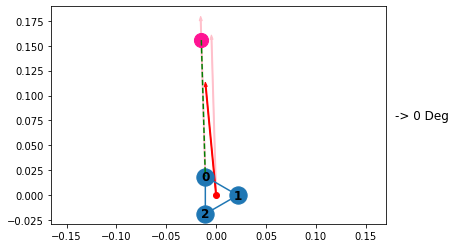

In [13]:
plt.scatter([0], [0], c="red") # Center of the triangle
plt.scatter(micX, micY, s=300) # Draw mic position
plt.plot(micX + micX[:1], micY + micY[:1]) # Draw outline
plt.scatter([sourcex], [sourcey], c="deeppink", s=200) # Source location

# Draw the order which mic receives the sound first
for i in range(len(mics)):
  plt.text(*mics[i], str(i), c="black", size="large", weight="bold", va="center", ha="center")
plt.figtext(0.92, 0.5, "-> 0 Deg", size="large", va="center")
plt.axis("equal")

# Draw the direction of the sound
half_dist = m.sqrt(sourcex**2 + sourcey**2)
res_true = m.atan2(sourcey - 0, sourcex - 0)
plt.arrow(0, 0, m.cos(res) * half_dist, m.sin(res) * half_dist, color="pink", zorder=-1)
plt.arrow(mics[0][0], mics[0][1], m.cos(res) * half_dist, m.sin(res) * half_dist, color="pink", zorder=-1)
plt.arrow(0, 0, m.cos(res_true) * half_dist*.7, m.sin(res_true) * half_dist*.7, color="red", zorder=-1)

# Draw line from source to mic one
plt.plot([sourcex, mics[0][0]], [sourcey, mics[0][1]], color="green", linestyle="dashed")